# Marmoset
Data and annotations from 

Some of the annotations were correcte manually (for instance, we split twitters into their individual component calls).


In [13]:
import numpy as np
from pprint import pprint
import das.predict, das.evaluate, das.utils_plot
import matplotlib.pyplot as plt
import librosa.feature, librosa.display

plt.style.use('../ncb.mplstyle')

In [2]:
# import flammkuchen
# res = flammkuchen.load(f'model/20210625_211637_results.h5')
# print(res.keys())
# np.savez('data.npz', x=res['x_test'], y_true=res['y_test'], samplerate_Hz=44_100)

In [3]:
with np.load('data.npz') as f:
    x = f['x']  # audio data
    y_true = f['y_true']  # manual annotations (groundtruth)
    samplerate_Hz = f['samplerate_Hz']  # audio sample rate

In [4]:
events, segments, class_probabilities, class_names = das.predict.predict(x, 
                                                           model_save_name='model/20210625_211637',
                                                           verbose=1,
                                                           segment_thres=0.5,
                                                           segment_minlen=0.005,
                                                           segment_fillgap=0.005)


/Users/clemens10/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/Users/clemens10/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


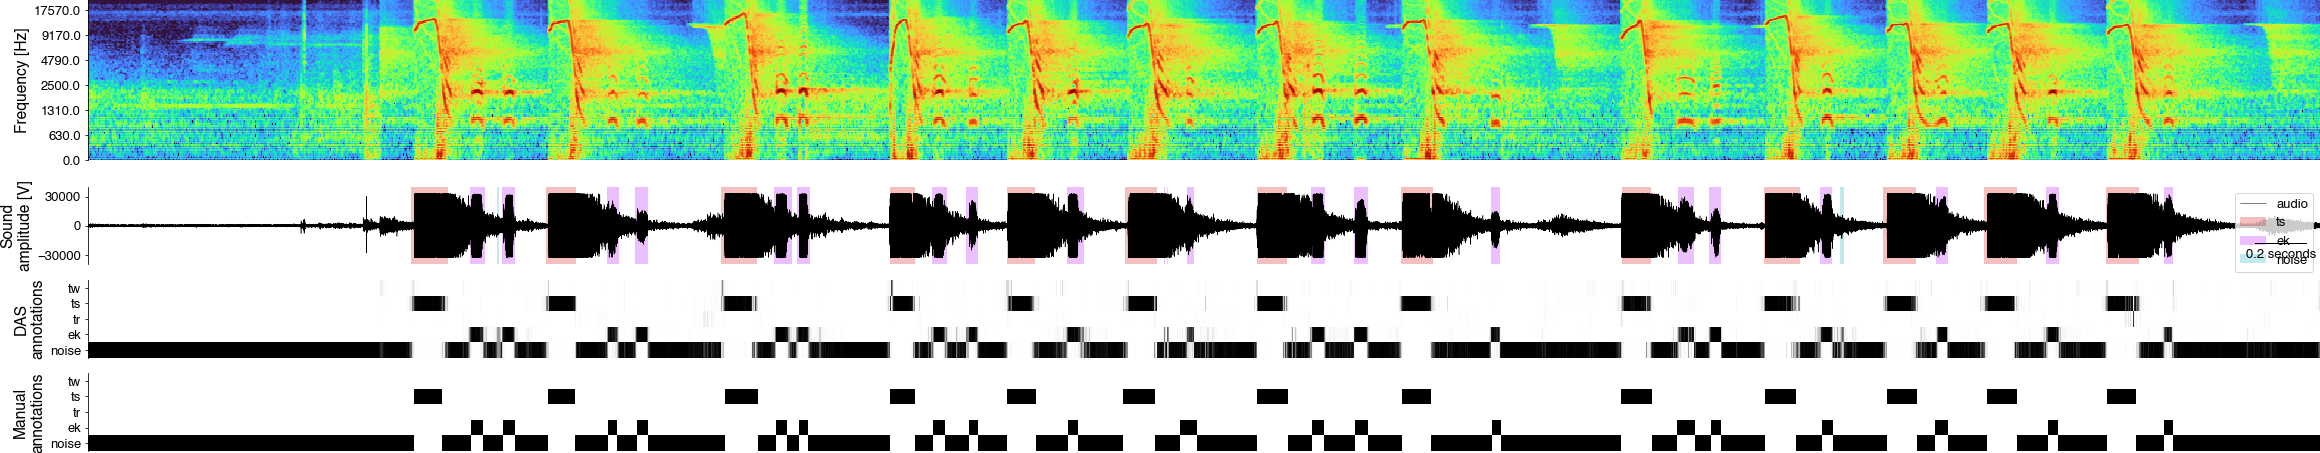

In [22]:
i0 = int((1118) * samplerate_Hz)
i1 = int(i0 + 8.5 * samplerate_Hz)
T = np.arange(i0, i1) / samplerate_Hz

specgram = librosa.feature.melspectrogram(x[i0:i1, 0], sr=samplerate_Hz, n_fft=512 + 256, hop_length=100, power=1)
specgram = librosa.amplitude_to_db(specgram, ref=np.max(specgram))
freqs = np.round(librosa.mel_frequencies(n_mels=128, fmin=0.0, fmax=samplerate_Hz/2, htk=False)/10) * 10

plt.figure(figsize=(40, 10))
plt.subplot(311)
plt.imshow(specgram, cmap='turbo')
plt.ylim(0, 128)
plt.yticks(np.arange(0, 128, 20), freqs[np.arange(0, 128, 20)])
plt.ylabel('Frequency [Hz]')
das.utils_plot.despine(which='tbr')

plt.subplot(613)
plt.plot(T, x[i0:i1], c='k', linewidth=0.5, label='audio')
das.utils_plot.annotate_segments(onset_seconds=segments['onsets_seconds'], offset_seconds=segments['offsets_seconds'], 
                  segment_names=[segments['names'][ii] for ii in segments['sequence']], 
                  tmin=T[0], tmax=T[-1])
plt.xlim(T[0], T[-1])
plt.ylim(-4.0e4, 4.0e4)
plt.yticks(np.arange(-3e4, 3.1e4, 3e4))
plt.legend(loc='upper right', frameon=True, facecolor='w')
plt.ylabel('Sound\namplitude [V]')
das.utils_plot.despine(which='tbr')
das.utils_plot.scalebar(length=0.2, units='seconds')

plt.subplot(614)
plt.imshow(segments['probabilities'][i0:i1, :].T, cmap='Greys')
plt.yticks(np.arange(len(class_names)), labels=class_names)
plt.ylabel('DAS\nannotations')
das.utils_plot.despine(which='tbr')

plt.subplot(615)
plt.imshow(y_true[i0:i1].T, cmap='Greys')
plt.yticks(np.arange(len(class_names)), labels=class_names)
plt.ylabel('Manual\nannotations')
das.utils_plot.despine(which='tbr')
plt.show()

Classification report
              precision    recall  f1-score   support

       noise      0.991     0.992     0.992   1402370
          ek      0.567     0.937     0.706      8037
          tr      0.945     0.856     0.898     65336
          ts      0.900     0.925     0.913     11608
          tw      0.856     0.841     0.848     14113

    accuracy                          0.984   1501464
   macro avg      0.852     0.910     0.871   1501464
weighted avg      0.985     0.984     0.984   1501464

Confusion matrix
            true noise  true ek  true tr  true ts  true tw
pred noise     1391130     5299     2993     1060     1888
pred ek            510     7527        0        0        0
pred tr           8879      436    55930        0       91
pred ts            747       19       86    10740       16
pred tw           1922        0      198      130    11863


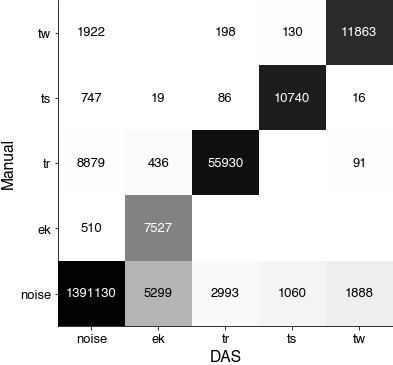

In [14]:
# evaluate performance for individual call tyes
min_len = min(y_true.shape[0], segments['samples'].shape[0])
labels_true = np.argmax(y_true[:min_len], axis=1)
labels_pred = segments['samples'][:min_len]
step = int(samplerate_Hz / 1_000)
confmat, report = das.evaluate.evaluate_segments(labels_true[::step], labels_pred[::step], class_names, confmat_as_pandas=True, report_as_dict=False)
print('Classification report (sample-wise)')
print(report)

confmat_norm = confmat / np.sum(confmat, axis=0) * 100
nb_classes = len(class_names)

print('Confusion matrix (sample-wise)')
print(confmat)

plt.figure(figsize=(6, 6))
plt.imshow(confmat_norm, cmap='Greys')
plt.clim(0, 100)
plt.xticks(np.arange(nb_classes), labels=class_names)
plt.yticks(np.arange(nb_classes), labels=class_names)
plt.xlabel('DAS')
plt.ylabel('Manual')
das.utils_plot.imshow_text(confmat_norm.values, confmat.values)


# Evaluate the temporal precision of the detected on- and offsets
True/false positives/negatives are determined based on a distance threshold - in short, any detected on- or offset with a true on- or offset counts as a true positive. The precision, recall, and F1-score are calculated accordingly.

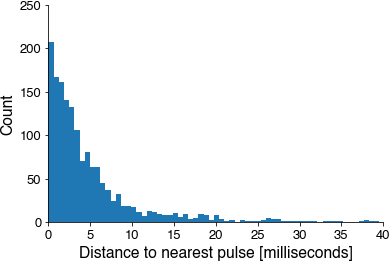

{'FN': 107,
 'FP': 377,
 'TP': 1537,
 'f1_score': 0.8639685216413715,
 'precision': 0.803030303030303,
 'recall': 0.9349148418491484}


In [21]:
tol = 0.04  # s
onsets_true, offsets_true = das.evaluate.segment_timing((labels_true>0).astype(np.float), samplerate_Hz)
onsets_pred, offsets_pred = das.evaluate.segment_timing((labels_pred>0).astype(np.float), samplerate_Hz)

on_or_offsets_true = np.concatenate((onsets_true, offsets_true))
on_or_offsets_pred = np.concatenate((onsets_pred, offsets_pred))

report_timing,  _, _, dist_to_nearest_on_or_offset = das.event_utils.evaluate_eventtimes(on_or_offsets_true, on_or_offsets_pred, samplerate_Hz, tol)

plt.hist(dist_to_nearest_on_or_offset[dist_to_nearest_on_or_offset<tol] * 1000, bins=64)
plt.xlabel('Distance to nearest pulse [milliseconds]')
plt.ylabel('Count')
plt.show()

pprint(report_timing)